$$\textbf{Machine Learning. Tarea 3: Retropropagación: Autoencoder }$$
$$\textit{Y. Sarahi García Gozález}$$

Instrucciones

Considerando la implementation de BackPropagation en las notas 

Usando datos de MNIST de dimensión d0=784 (esto es imágenes de 28x28)
Implemente un modelo de Autocodificador con:

1. Primer capa oculta de dimension d1 (digamos 128)
2. segunda capa oculta de dimensión d2< d1 (digamos 16)
3. capa de salida de dimension d3=d0 (784)
   
Ponga use las función de activación que considere adecuadas en cada capa
* Use como función de costo || y -ypred || donde y es la salida esperada (en este caso iguala a la entrada) y ypred es la salida del autoencoder.
* Derive las formulas de gradiente mediante Backpropagation.
* Implemente un algoritmo de descenso de gradiente estocástico únicamente en numpy basado en el ejemplo de las notas.<font size=4 color='mediumslateblue'>  

$\textit{Librerías}$<font size=4 color='mediumslateblue'>  



In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
print("Tarea realizada en Kaggle. \nLas versiones de las librerías y de python utilizadas fueron:\n")
from platform import python_version
print("Python version:", python_version())
print("NumPy version:", np.__version__)




Tarea realizada en Kaggle. 
Las versiones de las librerías y de python utilizadas fueron:

Python version: 3.10.13
NumPy version: 1.26.4



**Cargar la base de datos MNIST**

In [3]:
# Cargar datos MNIST
mnist = fetch_openml("mnist_784",parser='auto')

#El objetivo del autoencoder es reconstruir las entradas, por lo que las etiquetas no son necesarias. Sólo cargamos X
X, _ = mnist.data, mnist.target.astype(int)

# Normalizar datos
X = X / 255.0

 # Separar en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [4]:
 # dimensiones de los conjuntos
print("Train shape: ",X_train.shape)
print("Test shape: ",X_test.shape)

Train shape:  (56000, 784)
Test shape:  (14000, 784)


**Funciones de activación**

In [5]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))



**Inicializar pesos y biases**

In [6]:
input_size = 784
hidden_size_1 = 128
hidden_size_2 = 16
output_size = 784

#np.random.seed(0)  # descomentar si queremos replicar el entrenamiento
W1 = np.random.randn(input_size, hidden_size_1) * 0.1
b1 = np.zeros((1, hidden_size_1))
W2 = np.random.randn(hidden_size_1, hidden_size_2) * 0.1
b2 = np.zeros((1, hidden_size_2))
W3 = np.random.randn(hidden_size_2, output_size) * 0.1
b3 = np.zeros((1, output_size))

**Parámetros de entrenamiento**

In [19]:
learning_rate = 1e-4
epochs = 100

**Ciclo de entrenamiento**


Cada ciclo consiste en realizar los siguientes pasos:

1. Propagación hacia adelante:
* Evaluar el autoencoder con los datos en el lote actual.
* Este paso implica calcular las activaciones en cada capa utilizando las funciones de activación definidas.
2. Evaluar la función de pérdida:
* Calcular la pérdida entre la salida esperada (que en este caso es igual a la entrada) y la salida del autoencoder utilizando la función de costo ||y-y_pred||.
3. Retropropagación:
* Calcular las derivadas del modelo respecto a sus parámetros. Este paso reutiliza parte de los cálculos obtenidos en el paso 1.
* La retropropagación implica calcular los gradientes de la función de pérdida con respecto a cada parámetro del modelo (pesos y biases).
4. Ajustar los parámetros del modelo:
* Utilizar el algoritmo de descenso de gradiente estocástico para actualizar los parámetros del modelo (pesos y biases) en función de los gradientes calculados.

Estos pasos se repiten hasta que se alcance el criterio de paro (por iteraciones o por magnitud del gradiente).

In [8]:
#Primero definimos la propagación hcia ddelasnte y haci atrás

# Propagación hacia adelante
def forward_pass(X):
    z1 = np.dot(X, W1) + b1
    y1 = relu(z1)
    z2 = np.dot(y1, W2) + b2
    y2 = relu(z2)
    z3 = np.dot(y2, W3) + b3
    y3 = sigmoid(z3)
    return z1, y1, z2, y2, z3, y3

# Retropropagación
# Retropropagación
def backward_pass(X, y, z1, y1, z2, y2, z3, y3):
    m = X.shape[0]

    delta_3 = np.array(y3 - y)
    grad_W3 = np.dot(y2.T, delta_3) / m
    grad_b3 = np.sum(delta_3, axis=0) / m

    delta_2 = np.dot(delta_3, W3.T) * relu_derivative(z2)
    grad_W2 = np.dot(y1.T, delta_2) / m
    grad_b2 = np.sum(delta_2, axis=0) / m

    delta_1 = np.dot(delta_2, W2.T) * relu_derivative(z1)
    grad_W1 = np.dot(X.T, delta_1) / m
    grad_b1 = np.sum(delta_1, axis=0) / m

    return grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3

# Función de costo (norma L2)
def norm(y_true, y_pred):
    return np.mean(np.sqrt(np.sum((y_true - y_pred) ** 2, axis=1)))



In [20]:
Losses=[]
# Entrenamiento con registro de pérdidas
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(X_train.shape[0]):
        
        X_batch = X_train[i:i+1]
        y_batch = X_batch
        
        # Propagación hacia adelante, Eqs. (1)
        z1, y1, z2, y2, z3, y3 = forward_pass(X_batch)
        
        
        # Backpropagation, Eqs. (3) y (4)
        grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = backward_pass(X_batch, y_batch, z1, y1, z2, y2, z3, y3)

        # Paso de descenso de gradiente, Eq. (5)
        W1 -= learning_rate * grad_W1
        b1 -= learning_rate * grad_b1
        W2 -= learning_rate * grad_W2
        b2 -= learning_rate * grad_b2
        W3 -= learning_rate * grad_W3
        b3 -= learning_rate * grad_b3

        # Evaluar la pérdida, Eq. (2)
        epoch_loss += norm(y_batch, y3)
    
    Losses.append(epoch_loss / X_train.shape[0])
    
    # Reporta avence cada 10 épocas
    if epoch % 1 == 0:
        print(f'Epoch {epoch*}, Loss: {Losses[-1]}')

Epoch 0, Loss: 3.4473237736289857
Epoch 10, Loss: 3.446829131205568
Epoch 20, Loss: 3.4460896493680524
Epoch 30, Loss: 3.4453437476456608
Epoch 40, Loss: 3.444595670372949
Epoch 50, Loss: 3.4438540818399637
Epoch 60, Loss: 3.4431187641975667
Epoch 70, Loss: 3.442398156454095
Epoch 80, Loss: 3.4416755030336073
Epoch 90, Loss: 3.4409493352480567


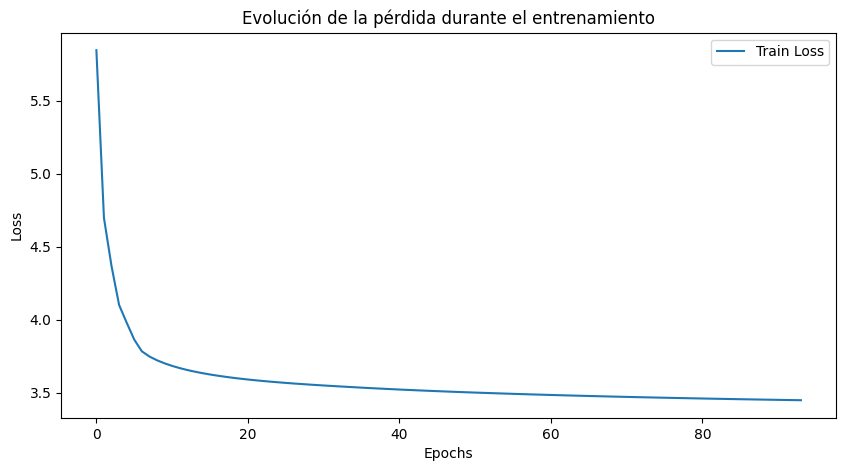

In [10]:
# Gráfica de la evolución de la pérdida
plt.figure(figsize=(10, 5))
plt.plot(Losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.legend()
plt.show()



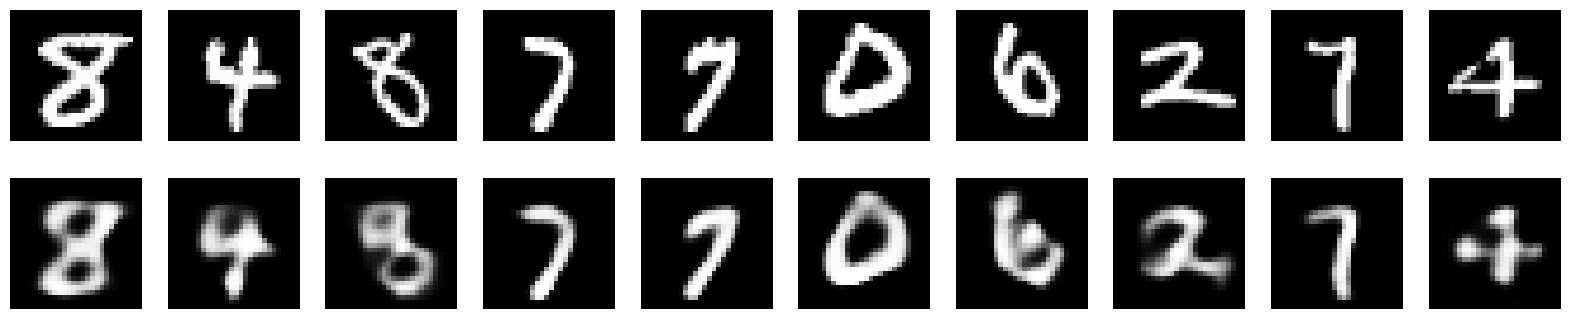

In [28]:
# Predicción
def predict(X):
    _, _, _, _, _, y3 = forward_pass(X)
    return y3
# Predicción en el conjunto de prueba
X_test_pred = predict(X_test)


#originales y reconstruidas
num_images = 10
plt.figure(figsize=(20, 4))
for i in range(num_images):
    # Originales
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(X_test.iloc[i].values.reshape(28, 28), cmap='gray')
    ax.axis('off')

    # Reconstruidas
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(X_test_pred[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()